## Regression of a function with a neural network in 1D

### Exercise 2:
Modify the code to solve the differential equation
$$
\frac{dy}{dx} = -y(x);\; y(0) = 1
$$
using
 a) finite difference method to calculate derivatives.
 b) automatic differentiation to calculate derivatives. 
Add boundary conditions as another loss function.

### Exercise 3:
Solve the same differential equation using
$$
y = 1+x\,\mathrm{Net}(x)
$$
This way we do not need to add another loss function.

### Exercise 4:
Solve the differential equation
$$
\frac{dy}{dx} = -y\,(x-1);\; y(0) = 1
$$
Run the code twice to see whether the results are the same. The results for two successive runs may not be the same. Explain why this is the case.

c:\Users\jakob\miniconda3\envs\torchenv\lib\site-packages\ipykernel_launcher.py:46: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:485.)


0   0.2461654245853424
10   0.014338841661810875
20   0.0001751396048348397
30   9.966886864276603e-06
40   7.012022251728922e-07
50   3.810939404047531e-07
60   3.725593273884442e-07
70   3.6499943689705105e-07
80   3.5816549370792927e-07
90   3.520152631608653e-07
Final loss: 0.126759871840477


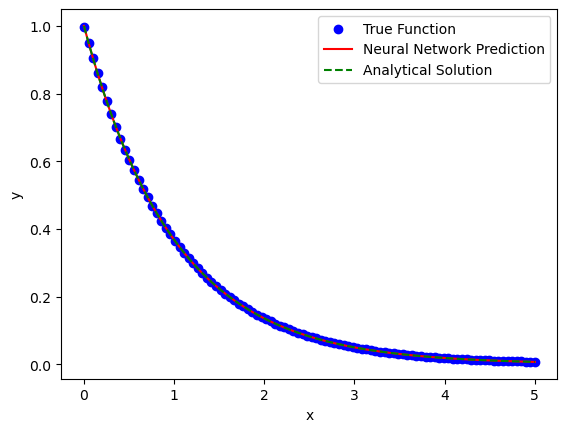

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt



# Generate synthetic data
x = torch.linspace(0, 5, 100)
x.requires_grad = True
x = x.unsqueeze(-1)

# Define a simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        # self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        # x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the neural network
net = Net()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.LBFGS(net.parameters(), lr=0.01)


def true_function(x, net):
    y = net(x)
    # if y.grad is None:
    #     h = 0.001
    #     dydx = (net(x + h) - y) / h
    #     print("x.grad is None")
    # else:
    #     dydx = y.grad
    if x.grad is None:
        dydx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    else:
        dydx = x.grad
    
    return -dydx

# Training loop
for i in range(100):
    def closure():
        optimizer.zero_grad()
        outputs = net(x)
        y = true_function(x, net)
        loss = criterion(outputs, y) + torch.square(net(torch.tensor([0.])) - torch.tensor( [1.]))/10.
        loss.backward(retain_graph=True)
        return loss

    loss=optimizer.step(closure)

    if(i%10==0):
      print(i," ",loss.item())
# Print the final loss
      
y = true_function(x, net).detach()

with torch.no_grad():
    outputs = net(x)
    loss = criterion(outputs, y.unsqueeze(-1))

print(f'Final loss: {loss.item()}')

x = x.detach().numpy()
# Plot the results
plt.scatter(x, y.detach().numpy(), label='True Function', color='blue')
plt.plot(x, outputs.numpy(), label='Neural Network Prediction', color='red')
plt.plot(x, np.exp(-x), '--', label='Analytical Solution', color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()